In [38]:
import scrapy
from scrapy.crawler import CrawlerProcess
from scrapy.item import Item
import json
import plotly.express as px
import plotly.graph_objects as go

In [2]:
class Elhunyt(Item):
    Sorszam = scrapy.Field()
    Nem = scrapy.Field()
    Kor = scrapy.Field()
    Alapbetegsegek = scrapy.Field()

In [3]:
class CovidHalalozas(scrapy.Spider):
    name="CovidHalalozasSpider"
    
    start_urls = ['https://koronavirus.gov.hu/elhunytak?page=%s' % page for page in range(0,21)]
    
    def parse(self, response):
        tableRows = response.xpath('//*[@id="block-system-main"]/div/div[2]/table/tbody/tr')
        for tableRow in tableRows:
            elhunyt = Elhunyt()
            elhunyt['Sorszam'] = tableRow.xpath('td[contains(@class, \'views-field-field-elhunytak-sorszam\')]/text()').extract()[0]
            elhunyt['Nem'] = tableRow.xpath('td[contains(@class, \'views-field-field-elhunytak-nem\')]/text()').extract()[0]
            elhunyt['Kor'] = tableRow.xpath('td[contains(@class, \'views-field-field-elhunytak-kor\')]/text()').extract()[0]
            elhunyt['Alapbetegsegek'] = tableRow.xpath('td[contains(@class, \'views-field-field-elhunytak-alapbetegsegek\')]/text()').extract()[0]                        
            yield elhunyt

In [ ]:
process = CrawlerProcess({
    'USER_AGENT': 'Mozilla/4.0 (compatible; MSIE 7.0; Windows NT 5.1)',
    "FEEDS": {
        "elhunytak.json": {"format": "json"},
    }
})

process.crawl(CovidHalalozas)
process.start() # the script will block here until the crawling is finished

('veseátültetés után lévő személy', 1)
('korábban leukémia miatt csontvelő transzplantáció', 1)
('vesetranszplantált', 1)
('vesetranszplantáció', 1)


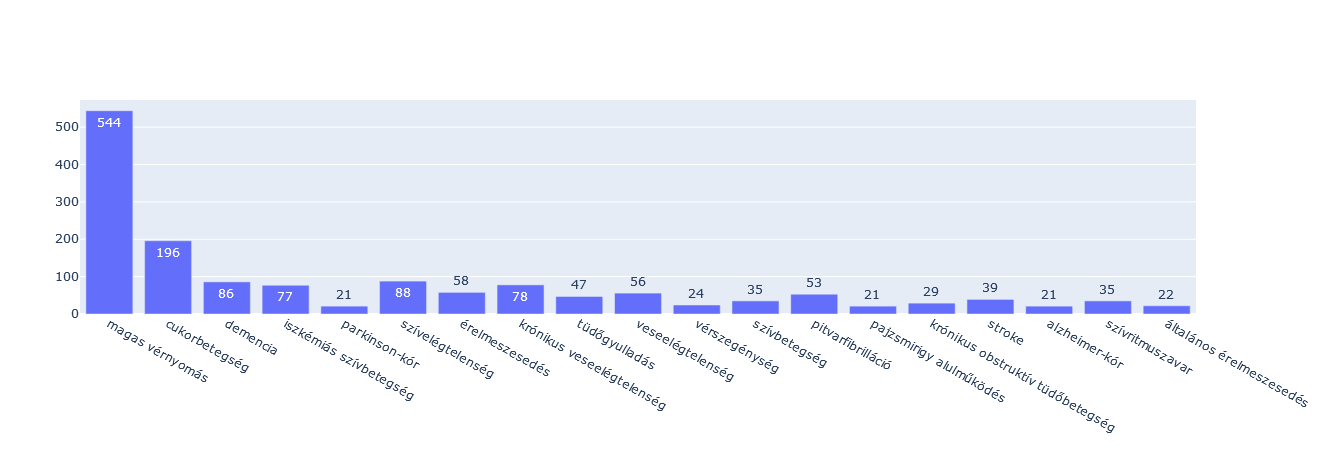

In [46]:
json_file = r'elhunytak.json'

class Megboldogult:
    def __init__(self, sor, nem, kor, ab):
        self.sorszam = sor
        self.nem = nem
        self.kor = kor
        self.alapbetegseg = ab

with open(json_file) as json_data:
    data = json.load(json_data)
    
elhunytak = [Megboldogult(e['Sorszam'], e['Nem'], e['Kor'], e['Alapbetegsegek']) for e in data]
alapbetegsegek = []
for e in elhunytak:
    for ab in e.alapbetegseg.split(","):
        alapbetegsegek.append(ab.strip().lower())

class BetegsegGyakorisag(dict):
    def __missing__(self, key):
        return False 

betegsegGyakorisag = BetegsegGyakorisag()
        
for betegseg in alapbetegsegek:
    if(betegsegGyakorisag[betegseg]):
        betegsegGyakorisag[betegseg] += 1
    else:
        betegsegGyakorisag[betegseg] = 1

gyakoriBetegsegek = {}
for elem in betegsegGyakorisag.items():
    if ("átü" in elem[0] or "tran" in elem[0]):
        print(elem)
    if(elem[1] > 20):
        gyakoriBetegsegek[elem[0]] = elem[1]
        

        
gyakoriBetegsegek = {'betegseg': gyakoriBetegsegek.keys(), 'fi': gyakoriBetegsegek.values()}
#fig = px.bar(gyakoriBetegsegek, x='betegseg', y='fi')
#fig.show()
x_teng = list(gyakoriBetegsegek['betegseg'])
y_teng = list(gyakoriBetegsegek['fi'])
fig = go.Figure(data=[go.Bar(
            x=x_teng, y=y_teng,
            text=y_teng,
            textposition='auto',
        )])

fig.show()